# Compute the equivalent layer via Fourier transform

This code illustrates how to compute the equivalent layer in Fourier domain.

### Things we have to import

In [1]:
import numpy as np
from scipy.fft import fft2, ifft2, fftshift, ifftshift, fftfreq
from numba import njit
import matplotlib.pyplot as plt
import prism
import plot_functions as plf

### Model

In [2]:
# Create a model formed by prisms
model = np.array([[2000., 3000., -1500., -500., 10., 1010.], 
                  [1600., 2600., -2500., -1500., 10., 1010.], 
                  [-1000., 1000., 1500, 2500, 10., 1010.],
                  [-3000., -2000., 1000, 3500., 10., 1010.]])

# magnetization of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
inc, dec = 3, -45
magnetization = np.array([[1.4, inc, dec],
                          [1.3, inc, dec],
                          [1.1, inc, dec],
                          [1.2, inc, dec]])

# magnetization used to compute the true RTP of each prism
# first, second and third columns contain
# the magnetization intensity (in A/m), inclination 
# and declination (in degrees) of the sources
magnetization_vertical = np.array([[1.4, 90, 0],
                                   [1.3, 90, 0],
                                   [1.1, 90, 0],
                                   [1.2, 90, 0]])

# density
density = magnetization[:,0]

### Points were we compute the synthetic data

In [3]:
# number of points along y and x
shape = (80, 80)

# minimum y, maximum y, minimum x and maximum x
area = [-5000, 5000, -4000, 6000]

# coordinates 
yp = np.linspace(area[0], area[1], shape[0])
xp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)
yp = np.ravel(yp)
xp = np.ravel(xp)
zp = np.zeros_like(yp) - 500

coordinates = np.vstack([yp, xp, zp])

### Main field

In [4]:
# reference point
yc, xc = 0, 1000

# inclination (degrees)
#I0 = -36 - 1e-5*(xp-xc) + 3e-5*(yp-yc) + 0*(xp-xc)*(xp-xc) + 1e-8*(yp-yc)*(yp-yc)
I0 = np.zeros_like(xp) - 36

# declination (degrees)
#D0 = 45 + 6e-6*(xp-xc) + 1e-5*(yp-yc) + 0*(xp-xc)*(xp-xc) + 4e-9*(yp-yc)*(yp-yc)
D0 = np.zeros_like(xp) + 45

# intensity (nT)
#F0 = 23400 + 1e-5*(xp-xc) + 1e-5*(yp-yc) + 0*(xp-xc)*(xp-xc) + 0*(yp-yc)*(yp-yc)
F0 = np.zeros_like(xp) + 23400

# Cartesian components of the main field
cosI0 = np.cos(np.deg2rad(I0))
sinI0 = np.sin(np.deg2rad(I0))
cosD0 = np.cos(np.deg2rad(D0))
sinD0 = np.sin(np.deg2rad(D0))
Fx = F0*cosI0*cosD0
Fy = F0*cosI0*sinD0
Fz = F0*sinI0

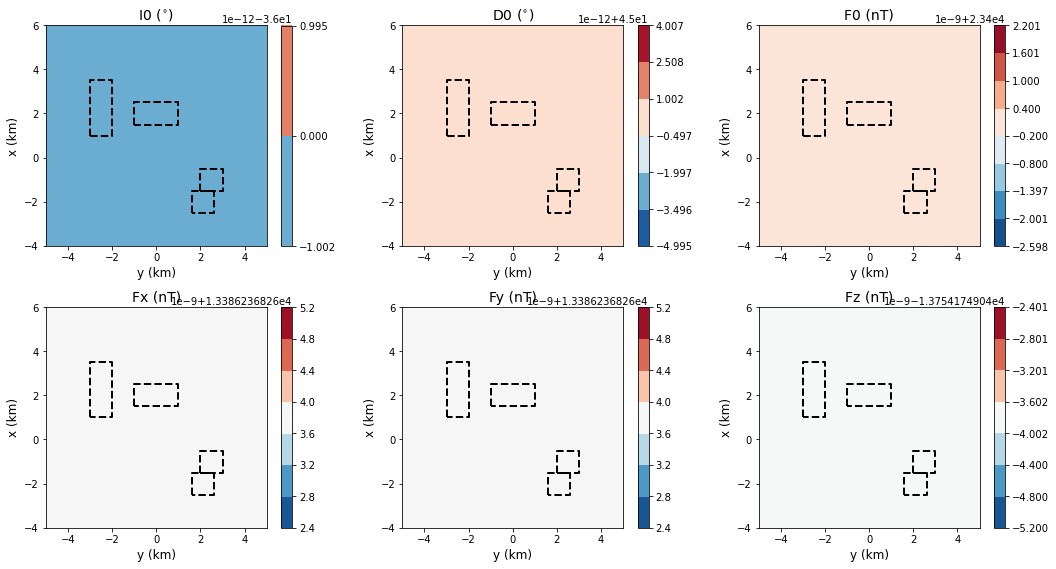

In [5]:
fields = [I0, D0, F0, Fx, Fy, Fz]
windows = [1, 2, 3, 4, 5, 6]
titles = ['I0 ($^{\circ}$)', 'D0 ($^{\circ}$)', 'F0 (nT)',
          'Fx (nT)', 'Fy (nT)', 'Fz (nT)']

plt.figure(figsize=(15,8))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Anomalous magnetic field

In [6]:
# Compute the magnetic field components
bx = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_x')
by = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_y')
bz = prism.mag(coordinates=coordinates, prisms=model, magnetization=magnetization, field='b_z')

# Compute the total-field anomaly
tfa = np.sqrt((Fx+bx)**2 + (Fy+by)**2 + (Fz+bz)**2) - F0

# Compute the approximated total-field anomaly
mean_I0 = np.mean(I0)
mean_D0 = np.mean(D0)
cos_mean_I0 = np.cos(np.deg2rad(mean_I0))
sin_mean_I0 = np.sin(np.deg2rad(mean_I0))
cos_mean_D0 = np.cos(np.deg2rad(mean_D0))
sin_mean_D0 = np.sin(np.deg2rad(mean_D0))
Fx_hat = cos_mean_I0*cos_mean_D0
Fy_hat = cos_mean_I0*sin_mean_D0
Fz_hat = sin_mean_I0
approx_tfa = Fx_hat*bx + Fy_hat*by + Fz_hat*bz
diff_tfa = approx_tfa - tfa

### RTP

In [7]:
# Compute the "true" RTP anomaly
rtp_anomaly = prism.mag(coordinates=coordinates, prisms=model, 
                        magnetization=magnetization_vertical, field='b_z')

### $\partial_{z}\Theta$ on the layer

In [20]:
# Compute the "true" gz on the layer
dz = 500
coordinates[2] += dz
dzTheta = prism.grav(coordinates=coordinates, prisms=model, 
                     density=prism.MAGNETIC_CONST*density/(prism.SI2MGAL*prism.GRAVITATIONAL_CONST), 
                     field='g_z')
coordinates[2] -= dz

### Plot the anomalous magnetic field

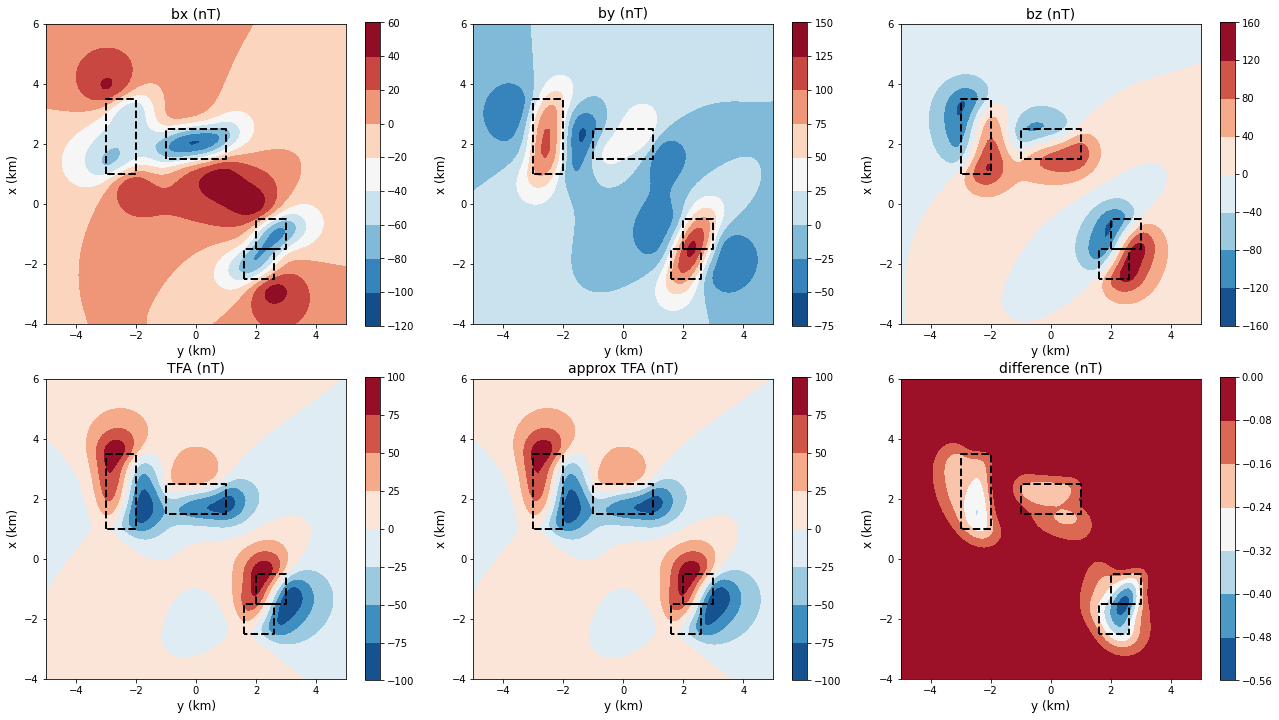

In [21]:
fields = [bx, by, bz, 
          tfa, approx_tfa, diff_tfa]
windows = [1, 2, 3, 4, 5, 6]
titles = ['bx (nT)', 'by (nT)', 'bz (nT)', 
          'TFA (nT)', 'approx TFA (nT)', 'difference (nT)']

plt.figure(figsize=(18,10))

for w, window in enumerate(windows):

    plt.subplot(2,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

### Plot the residual total-field anomaly and true RTP anomaly

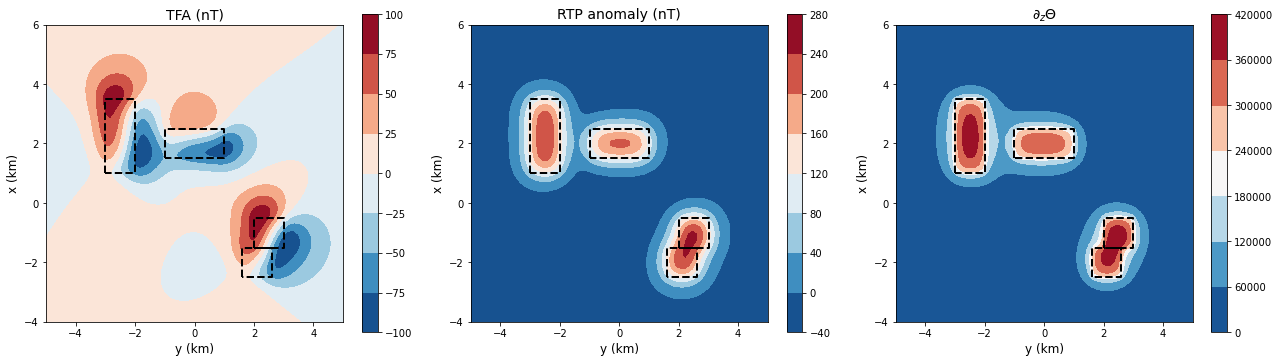

In [22]:
fields = [tfa, rtp_anomaly, dzTheta]
windows = [1, 2, 3]
titles = ['TFA (nT)', 'RTP anomaly (nT)', '$\partial_{z}\Theta$']

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r')
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()

In [23]:
np.mean(tfa), np.mean(rtp_anomaly)

(-0.10316344399263641, 9.573831123746281)

### Estimate the approximated total-field anomaly

In [24]:
# Add a noise to the synthetic data
#noise = np.random.normal(loc=0, scale=5, size=tfa.size)
#tfa += noise

# 2D Fourier transform of the dzTheta
F_dzTheta = fft2(dzTheta.reshape(shape))

# Grid spacing
dy = (area[1] - area[0])/(shape[0]-1)
dx = (area[3] - area[2])/(shape[1]-1)

# Frequencies kx = 2pi fx, ky = 2pi fy
fy = fftfreq(n=shape[0], d=dy)
fx = fftfreq(n=shape[1], d=dx)
Ky, Kx = np.meshgrid(fy, fx)
Kz = np.sqrt(Kx**2 + Ky**2)

# Components of the unit vector defining the
# total-magnetization direction
cos_inc = np.cos(np.deg2rad(inc))
sin_inc = np.sin(np.deg2rad(inc))
cos_dec = np.cos(np.deg2rad(dec))
sin_dec = np.sin(np.deg2rad(dec))
hx_hat = cos_inc*cos_dec
hy_hat = cos_inc*sin_dec
hz_hat = sin_inc

# direction filters (set the filter equal to 0 for Kz = 0)
null_Kz = (Kz == 0)
non_null_Kz = (Kz != 0)
phi_h = np.empty_like(Kz, dtype=complex)
phi_h[null_Kz] = 0
phi_h[non_null_Kz] = hz_hat + 1j*(Kx[non_null_Kz]*hx_hat + Ky[non_null_Kz]*hy_hat)/Kz[non_null_Kz]
phi_F = np.empty_like(Kz, dtype=complex)
phi_F[null_Kz] = 0
phi_F[non_null_Kz] = Fz_hat + 1j*(Kx[non_null_Kz]*Fx_hat + Ky[non_null_Kz]*Fy_hat)/Kz[non_null_Kz]

filter_eqlayer = np.empty_like(Kz, dtype=complex)
filter_eqlayer[null_Kz] = 0
filter_eqlayer[non_null_Kz] = phi_h[non_null_Kz]*phi_F[non_null_Kz]*Kz[non_null_Kz]*np.exp(-Kz[non_null_Kz]*dz)

# Estimated approximated total-field anomaly
F_estimated_approx_tfa = filter_eqlayer*F_dzTheta
estimated_approx_tfa = (ifft2(F_estimated_approx_tfa).real).ravel()
diff_approx_tfa = estimated_approx_tfa - approx_tfa

### Plot the results

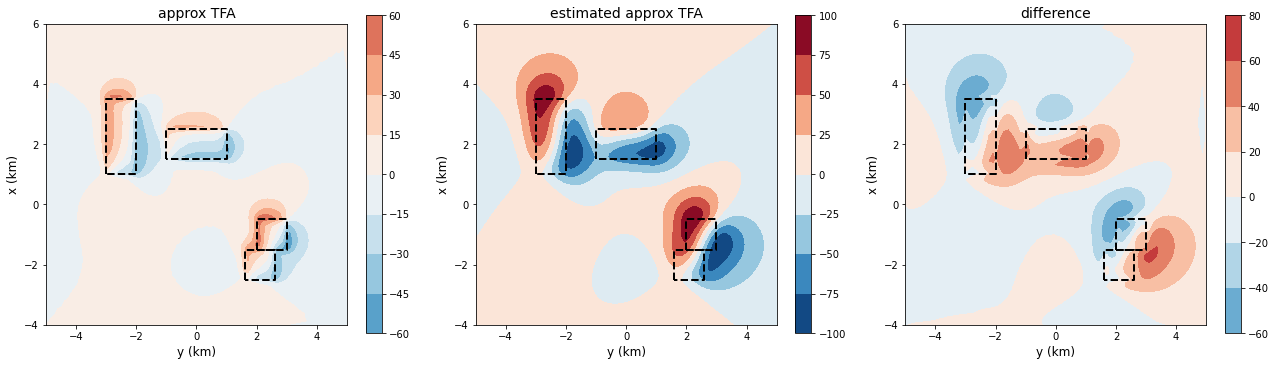

In [25]:
fields = [estimated_approx_tfa, approx_tfa, diff_approx_tfa]
windows = [1, 2, 3]
titles = ['approx TFA', 'estimated approx TFA', 'difference']

ranges_approx_tfa = np.max([np.abs(estimated_approx_tfa), np.abs(approx_tfa)])
ranges = [ranges_approx_tfa, ranges_approx_tfa, 100]

plt.figure(figsize=(18,5))

for w, window in enumerate(windows):

    plt.subplot(1,3,window)
    plt.title(titles[w], fontsize=14)
    plt.axis('scaled')
    plt.contourf(yp.reshape(shape)*0.001, 
                 xp.reshape(shape)*0.001, 
                 fields[w].reshape(shape), cmap='RdBu_r',
                 vmin=-ranges[w], vmax=ranges[w])
    plt.colorbar()
    plf.model_boundaries(model, m2km=True)
    plt.xlim(0.001*area[0], 0.001*area[1])
    plt.ylim(0.001*area[2], 0.001*area[3])
    plt.xlabel('y (km)', fontsize=12)
    plt.ylabel('x (km)', fontsize=12)

plt.tight_layout()

plt.show()